In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class DataGenerator:
    def __init__(self, num_generators, seed=5000, max_percentage=80, min_percentage=20):
        self.num_generators = num_generators
        np.random.seed(seed)

        # Define the observed capacities from Ireland data
        observed_capacities = np.array([90, 90, 90, 431, 402, 61, 118, 58, 58, 464, 339, 397, 17, 91, 285, 285, 285, 104, 463, 52, 52, 81, 81, 54, 54, 241, 243, 52, 52, 386, 137, 444])

        # Calculate the frequency of each capacity
        unique_capacities, counts = np.unique(observed_capacities, return_counts=True)

        # Create a probability distribution based on these frequencies
        probabilities = counts / len(observed_capacities)

        # Generate capacities
        self.capacities = np.random.choice(unique_capacities, size=self.num_generators, p=probabilities)

        # Add some randomness to reflect real-world variability but keep the distribution
        self.capacities = np.round(self.capacities * np.random.uniform(0.9, 1.1, self.num_generators)).astype(int)

        # Ensure no capacity goes below 1 MW
        self.capacities = np.maximum(self.capacities, 1)

        # Generating cost coefficients with bias for larger generators
        self.cost_coefficients = {
            'a': np.zeros(self.num_generators),
            'b': np.zeros(self.num_generators),
            'c': np.zeros(self.num_generators)
        }

        for i in range(self.num_generators):
            # Determine if it's a 'large' generator for cost bias
            if self.capacities[i] > 250:  # Assuming 250 MW is the threshold for 'large'
                # Lower cost for large generators at 25% to 75% load
                self.cost_coefficients['a'][i] = np.random.uniform(3, 10)  # Lower fixed cost for larger units
                self.cost_coefficients['b'][i] = np.random.uniform(10, 15)  # Lower linear cost
                self.cost_coefficients['c'][i] = np.random.uniform(0.001, 0.005)  # Lower quadratic cost for efficiency
            else:
                # Normal cost for smaller generators
                self.cost_coefficients['a'][i] = np.random.uniform(15, 30)
                self.cost_coefficients['b'][i] = np.random.uniform(15, 20)
                self.cost_coefficients['c'][i] = np.random.uniform(0.005, 0.01)

        # Generating transmission loss coefficients
        self.transmission_loss_coeffs = np.random.uniform(0.00001, 0.0001, self.num_generators)

        # Convert to PyTorch tensors with double precision
        self.capacities = torch.tensor(self.capacities, dtype=torch.double)
        self.a = torch.tensor(self.cost_coefficients['a'], dtype=torch.double)
        self.b = torch.tensor(self.cost_coefficients['b'], dtype=torch.double)
        self.c = torch.tensor(self.cost_coefficients['c'], dtype=torch.double)
        self.B = torch.tensor(self.transmission_loss_coeffs, dtype=torch.double)

        # Demand calculation
        self.total_capacity = self.capacities.sum()

        # Given demand profile (This is Irelands system profile for Jan 31 2025)
        original_demand = np.array([
        4630, 4630, 4585, 4585, 4480, 4480, 4363, 4363, 4287, 4287, 4324, 4324, 4274, 4274, 4224, 4224,
        4158, 4158, 4238, 4238, 4238, 4238, 4194, 4194, 4167, 4167, 4169, 4169, 4158, 4158, 4145, 4145,
        4134, 4134, 4129, 4129, 4115, 4115, 4121, 4121, 4160, 4160, 4212, 4212, 4229, 4229, 4283, 4283,
        4389, 4389, 4578, 4578, 4698, 4698, 4882, 4882, 5096, 5096, 5438, 5438, 5648, 5648, 5854, 5854,
        5899, 5899, 5960, 5960, 6014, 6014, 6066, 6066, 6131, 6131, 6202, 6202, 6196, 6196, 6189, 6189,
        6127, 6127, 6074, 6074, 6058, 6058, 6022, 6022, 5994, 5994, 5957, 5957, 5922, 5922, 5879, 5879,
        5827, 5827, 5826, 5826, 5799, 5799, 5774, 5774, 5747, 5747, 5697, 5697, 5634, 5634, 5614, 5614,
        5589, 5589, 5596, 5596, 5590, 5590, 5592, 5592, 5611, 5611, 5665, 5665, 5709, 5709, 5759, 5759,
        5798, 5798, 5867, 5867, 5947, 5947, 6025, 6025, 6117, 6117, 6256, 6256, 6423, 6423, 6508, 6508,
        6502, 6502, 6471, 6471, 6411, 6411, 6353, 6353, 6302, 6302, 6248, 6248, 6206, 6206, 6119, 6119,
        6014, 6014, 5932, 5932, 5865, 5865, 5794, 5794, 5668, 5668, 5568, 5568, 5488, 5488, 5389, 5389,
        5279, 5279, 5206, 5206, 5101, 5101, 4963, 4963, 4875, 4875, 4934, 4934, 4847, 4847, 4725, 4725
        ])

        # Resample to 48 points using interpolation
        resampled_demand = np.interp(np.linspace(0, 191, 48), np.arange(192), original_demand)

        min_original = np.min(original_demand)
        max_original = np.max(original_demand)

        # Use percentages of total capacity for demand scaling
        max_prev_demand = self.total_capacity.item() * (max_percentage / 100)
        min_prev_demand = self.total_capacity.item() * (min_percentage / 100)

        scale_factor = (max_prev_demand - min_prev_demand) / (max_original - min_original)
        demand_profile = min_prev_demand + (resampled_demand - min_original) * scale_factor
        demand_profile = np.round(demand_profile, decimals=2)

        # Convert to PyTorch tensors
        self.demand_profile = torch.tensor(demand_profile, dtype=torch.double)
        self.demand = self.demand_profile.clone().detach()

    def plot_demand_profile(self):
        plt.figure(figsize=(15, 7))
        plt.plot(np.linspace(0, 24, 48), self.demand_profile, label='Demand Profile')
        plt.xlabel('Time (hours)')
        plt.ylabel('Demand (MW)')
        plt.title('Daily Demand Profile')
        plt.grid(True)

        plt.axhline(y=self.total_capacity, color='r', linestyle='--', label='Total Capacity')
        plt.text(24.5, self.total_capacity, f'Total Capacity: {self.total_capacity.item():.2f} MW', verticalalignment='bottom')

        plt.legend()
        plt.show()

    def print_stats(self):
        print(f"Total Capacity: {self.total_capacity.item():.2f} MW")
        print(f"Demand: {self.demand.tolist()}")
        print(f"Average 'a' coefficient: {self.a.mean().item():.2f}")
        print(f"Average 'b' coefficient: {self.b.mean().item():.2f}")
        print(f"Average 'c' coefficient: {self.c.mean().item():.2f}")
        print(f"Average transmission loss coefficient: {self.B.mean().item():.6f}")
        print(f"Max Demand: {self.demand.max().item():.2f} MW")
        print(f"Min Demand: {self.demand.min().item():.2f} MW")
        print(f"Average Demand: {self.demand.mean().item():.2f} MW")

In [11]:
class HopfieldEconomicDispatch:
    def __init__(self, data_generator, c0, eta, iterations):
        self.n = data_generator.num_generators
        self.timesteps = len(data_generator.demand)
        self.demand = data_generator.demand
        print(f"Initialized Demand: {self.demand.tolist()}")
        self.capacities = data_generator.capacities
        self.a = data_generator.a
        self.b = data_generator.b
        self.c = data_generator.c
        self.B = data_generator.B.repeat(self.timesteps)
        print(f"Demand: {self.demand.tolist()}")
        print("Self Demand:" + str(self.demand))

        self.c0 = c0  # Store c0 for use in _build_T_matrix
        self.eta = eta  # Store eta for potential use in future methods
        self.iterations = iterations  # Store iterations for use in solve method

        print(f"c0: {self.c0}")
        print(f"eta: {self.eta}")
        print(f"iterations: {self.iterations}")

        # Initialize weights and biases for all timesteps
        self.T = self._build_T_matrix()
        self.i = self._build_i_vector()

        self.actual_demand_met_history = []
        self.cost_history_per_timestep = []
        self.cost_history = []
        self.generator_outputs_history = []
        self.gradient_history = []

    def _build_T_matrix(self):
        # Diagonal matrix for all timesteps
        T = torch.zeros(self.n * self.timesteps, self.n * self.timesteps, dtype=torch.double)
        for t in range(self.timesteps):
            T[t*self.n:(t+1)*self.n, t*self.n:(t+1)*self.n] = torch.diag(-2 * self.c)

        # Add some temporal coherence by linking same generators across timesteps
        for i in range(self.n):
            for t in range(self.timesteps - 1):
                T[i + t*self.n, i + (t+1)*self.n] = self.c0 * 0.01  # Small coupling for temporal coherence
                T[i + (t+1)*self.n, i + t*self.n] = self.c0 * 0.01

        return T

    def _build_i_vector(self):
        # Vector for all timesteps
        i = torch.zeros(self.n * self.timesteps, dtype=torch.double)
        for t in range(self.timesteps):
            i[t*self.n:(t+1)*self.n] = -self.b
        return i

    def activation_function(self, x, actual_demand_met, target_demand):
        # Example: increase tolerance if demand is not met
        tolerance = 1e-6 + max(0, (torch.abs(actual_demand_met - target_demand) / target_demand).mean().item()) * 1e-3
        return torch.clamp(x, min=torch.zeros_like(self.capacities).repeat(self.timesteps),
                       max=self.capacities.repeat(self.timesteps) + tolerance)

 #   def initialize_state(self):
 #       u = torch.zeros(self.n * self.timesteps, dtype=torch.double)

 #       for t in range(self.timesteps):
            # Sort generators by cost efficiency (lower 'c' means more efficient)
 #           sorted_indices = torch.argsort(self.c)

 #           remaining_demand = self.demand[t].item()

 #           total_capacity = self.capacities.sum()

#            for i in sorted_indices:
#                if remaining_demand <= 0:
#                    break  # Stop if demand is met or exceeded

                # Distribute demand proportionally to capacity but with a bias towards efficiency
#                capacity_fraction = self.capacities[i] / total_capacity
#                proposed_output = min(remaining_demand * capacity_fraction * 2, self.capacities[i])  # Bias towards using generator more if it's efficient

                # Ensure we don't exceed demand or capacity
#                u[i + t*self.n] = min(proposed_output, remaining_demand)
#                remaining_demand -= u[i + t*self.n]

            # Ensure outputs are within capacity limits
#            u[t*self.n:(t+1)*self.n] = torch.clamp(u[t*self.n:(t+1)*self.n],
#                                              min=torch.zeros_like(self.capacities),
#                                              max=self.capacities)

            # If demand isn't met, distribute the remaining demand evenly among unused capacity
#            if remaining_demand > 0:
#                unused_capacity = (self.capacities - u[t*self.n:(t+1)*self.n].clamp(max=0)).sum()
#                if unused_capacity > 0:  # Avoid division by zero
#                    additional_output = remaining_demand * (self.capacities - u[t*self.n:(t+1)*self.n]) / unused_capacity
#                    u[t*self.n:(t+1)*self.n] += additional_output.clamp(max=remaining_demand)
                    # Recalculate remaining demand after additional distribution
#                    remaining_demand = max(0, remaining_demand - additional_output.sum())

#        return u

    def initialize_state(self):

        u = torch.zeros(self.n * self.timesteps, dtype=torch.double)

        for t in range(self.timesteps):
            # Sort generators by cost efficiency (lower 'c' means more efficient)
            sorted_indices = torch.argsort(self.c)

            remaining_demand = self.demand[t].item()

            total_capacity = self.capacities.sum()

            for i in sorted_indices:
                if remaining_demand <= 0:
                    break  # Stop if demand is met or exceeded

                # Distribute demand proportionally to capacity but with a bias towards efficiency
                capacity_fraction = self.capacities[i] / total_capacity
                proposed_output = min(remaining_demand * capacity_fraction * 2, self.capacities[i])  # Bias towards using generator more if it's efficient

                # Ensure we don't exceed demand or capacity
                u[i + t*self.n] = min(proposed_output, remaining_demand)
                remaining_demand -= u[i + t*self.n]


            # Ensure outputs are within capacity limits
            u[t*self.n:(t+1)*self.n] = torch.clamp(u[t*self.n:(t+1)*self.n], min=torch.zeros_like(self.capacities), max=self.capacities)

            # If demand isn't met, distribute the remaining demand evenly among unused capacity
            if remaining_demand > 0:
                unused_capacity = (self.capacities - u[t*self.n:(t+1)*self.n].clamp(max=0)).sum()
                if unused_capacity > 0:  # Avoid division by zero
                    additional_output = remaining_demand * (self.capacities - u[t*self.n:(t+1)*self.n]) / unused_capacity
                    u[t*self.n:(t+1)*self.n] += additional_output.clamp(max=remaining_demand)
                    # Recalculate remaining demand after additional distribution
                    remaining_demand = max(0, remaining_demand - additional_output.sum())
        #print(f"Initial State: {u}")
        #print(f"Initial State Shape: {u.shape}")

        return u

    def calculate_dt(self, u, iteration=0):
        u_reshaped = u.reshape(self.timesteps, self.n)
        B_reshaped = self.B.reshape(self.timesteps, self.n)

        losses = torch.sum(B_reshaped * u_reshaped**2, dim=1)
        actual_demand_met = u_reshaped.sum(dim=1) - losses
        r = self.demand - actual_demand_met

        # Objective function gradient for all timesteps
        obj_gradient = self.T @ u + self.i

        # Constraint gradient for all timesteps
        constraint_gradient = torch.zeros_like(obj_gradient)
        for t in range(self.timesteps):
            A_eq = torch.ones(1, self.n, dtype=torch.double)
            constraint_gradient[t*self.n:(t+1)*self.n] = A_eq.T @ torch.pinverse(A_eq @ A_eq.T) @ torch.tensor([r[t]], dtype=torch.double)

        # Calculate dt for each timestep, then average
        dt_obj = - (obj_gradient @ obj_gradient) / (obj_gradient @ (self.T @ obj_gradient))

        # Expand r to match obj_gradient's shape for element-wise multiplication
        r_expanded = r.repeat_interleave(self.n)

        dt_constr = - (r_expanded * r_expanded) / (r_expanded * (self.T @ constraint_gradient))

        alpha = 0.5  # Balance between objective and constraints
        dt_combined = alpha * dt_obj.mean().item() + (1 - alpha) * dt_constr.mean().item()

        # Dynamic adjustment of dt
        base_max_dt = 0.1
        magnitude = abs(dt_combined)
        magnitude = magnitude / max(1, iteration)
        dt = min(base_max_dt, magnitude)

        # Add a decay factor to reduce dt over time for fine-tuning
        dt *= (0.9999 ** (iteration / 100))
        dt = max(min(dt, 1e-1), 1.1e-4)

        # ... existing code ...
        # After calculating dt:
        if iteration > 0 and iteration % 10 == 0:  # Check every 100 iterations
            if abs(self.actual_demand_met_history[-1][0] - self.actual_demand_met_history[-2][0]) < 1e-5:  # If little change
                dt *= 1.1  # Increase learning rate by 10%
                dt = min(dt, base_max_dt)  # Ensure it doesn't exceed maximum

        #print(f"Post DT Demand: {self.demand.tolist()}")

        return dt

    def step(self, u, iteration):
        dt = self.calculate_dt(u, iteration)

        u_reshaped = u.reshape(self.timesteps, self.n)
        B_reshaped = self.B.reshape(self.timesteps, self.n)

        losses = torch.sum(B_reshaped * u_reshaped**2, dim=1)
        actual_demand_met = u_reshaped.sum(dim=1) - losses
        power_balance_error = self.demand - actual_demand_met
        #print(f"Iteration {iteration}: Power Balance Error = {power_balance_error}")

        # Objective function gradient for all timesteps
        cost_gradient = - (self.T @ u + self.i)

        # Normalize cost gradient
        cost_norm = cost_gradient / (torch.norm(cost_gradient) + 1e-10)

        # Constraint gradient for all timesteps
        constraint_gradient = torch.zeros_like(cost_gradient)
        for t in range(self.timesteps):
            A_eq = torch.ones(1, self.n, dtype=torch.double)
            constraint_gradient[t*self.n:(t+1)*self.n] = A_eq.T @ torch.pinverse(A_eq @ A_eq.T) @ torch.tensor([power_balance_error[t]], dtype=torch.double)

        # Normalize constraint gradient
        constraint_norm = constraint_gradient / (torch.norm(constraint_gradient) + 1e-10)

        # Combine normalized gradients
        alpha = 0.5  # Balance between objective and constraints
        gradient = alpha * cost_norm + (1 - alpha) * constraint_norm

        # Record the gradient for PCA
        self.gradient_history.append(gradient.numpy())  # Convert to numpy for later use with sklearn


        u_proposed = u + dt * gradient

        #print(f"Iteration {iteration}: Cost Gradient Norm = {torch.norm(cost_gradient).item()}, Constraint Gradient Norm = {torch.norm(constraint_gradient).item()}")

        u_proposed_reshaped = u_proposed.reshape(self.timesteps, self.n)

        for t in range(self.timesteps):
            total_proposed = u_proposed_reshaped[t].sum()
            proposed_losses = torch.sum(B_reshaped[t] * u_proposed_reshaped[t]**2)
            actual_proposed_demand = total_proposed - proposed_losses

            if actual_proposed_demand > self.demand[t]:
                scale_factor = self.demand[t] / actual_proposed_demand
                u_proposed_reshaped[t] *= scale_factor
            elif actual_proposed_demand < self.demand[t]:
                scale_factor = self.demand[t] / max(actual_proposed_demand, 1e-6)
                u_proposed_reshaped[t] *= scale_factor

        # Here we pass actual_demand_met and self.demand to the activation function
        u_constrained = self.activation_function(u_proposed_reshaped.flatten(), actual_demand_met, self.demand)

        # Add noise periodically to escape local minima
        if iteration > 0 and iteration % 100 == 0:
            mask = (u_constrained != self.capacities.repeat(self.timesteps)) & (u_constrained != 0)
            noise = torch.randn_like(u_constrained) * 0.2
            u_constrained[mask] += noise[mask]
            u_constrained = self.activation_function(u_constrained, actual_demand_met, self.demand)

        self.generator_outputs_history.append(u_constrained.tolist())

        #print(f"Post Step Demand: {self.demand.tolist()}")

        return u_constrained


    def solve(self, tolerance=1e-6, patience=10):
        u = self.initialize_state()
        last_demand = float('-inf')
        last_cost = float('inf')
        patience_counter = 0

        for i in range(self.iterations):
            u = self.step(u, i)
            u_reshaped = u.reshape(self.timesteps, self.n)
            B_reshaped = self.B.reshape(self.timesteps, self.n)

            # Correct calculation of losses
            losses = torch.sum(B_reshaped * u_reshaped**2, dim=1)  # Sum over generators for each timestep
            total_power = u_reshaped.sum(dim=1)
            actual_demand_met = total_power - losses

            # Calculate cost per timestep
            cost_per_timestep = self.a + self.b * u_reshaped + self.c * u_reshaped**2
            cost_per_timestep = cost_per_timestep.sum(dim=1)  # Sum over generators for each timestep

            # Total cost for all timesteps
            cost = cost_per_timestep.sum().item()

            self.actual_demand_met_history.append(actual_demand_met.tolist())
            self.cost_history.append(cost_per_timestep.sum().item())  # Total cost for all timesteps
            self.cost_history_per_timestep.append(cost_per_timestep.tolist())  # Cost per timestep

            if i % 10 == 0:  # Print every 100 iterations to reduce output volume
                print(f"Iteration {i}: Average Actual Demand Met = {actual_demand_met.mean().item():.2f} MW, Cost = {cost:.2f} $/h")

            if abs(actual_demand_met.mean() - last_demand) < tolerance:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Converged at iteration {i}")
                    break
            else:
                patience_counter = 0
            last_demand = actual_demand_met.mean()
            last_cost = cost
            print(f"Iteration {i}: Shape of u = {u.shape}")
        return self.activation_function(u, actual_demand_met, self.demand)

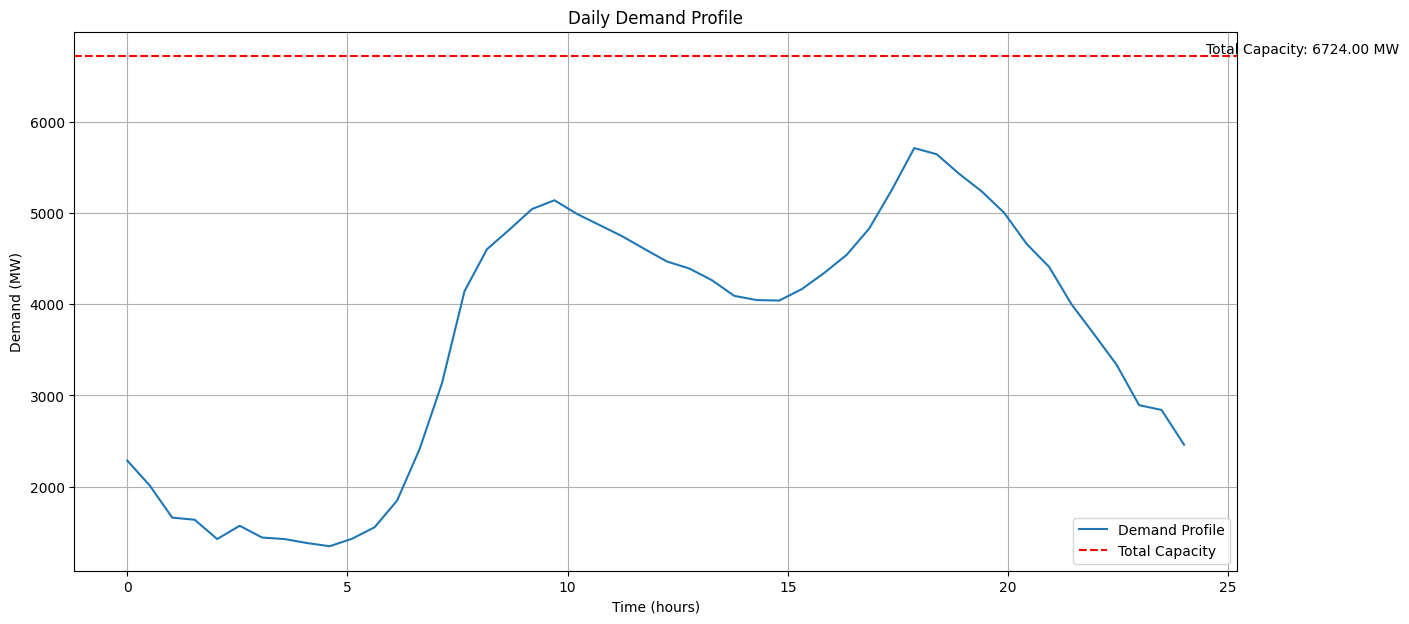

Total Capacity: 6724.00 MW
Demand: [2285.4, 2011.44, 1658.94, 1635.2, 1423.34, 1569.45, 1439.77, 1423.34, 1379.5, 1344.8, 1426.99, 1553.01, 1845.24, 2409.6, 3136.51, 4144.69, 4605.49, 4821.24, 5046.16, 5142.84, 4992.76, 4871.13, 4749.31, 4608.36, 4470.64, 4393.27, 4265.27, 4092.69, 4046.99, 4041.86, 4167.34, 4345.48, 4544.67, 4833.24, 5255.14, 5715.4, 5647.82, 5432.31, 5240.53, 5004.93, 4663.39, 4411.34, 3998.57, 3671.65, 3337.41, 2893.6, 2840.63, 2458.91]
Average 'a' coefficient: 17.66
Average 'b' coefficient: 16.00
Average 'c' coefficient: 0.01
Average transmission loss coefficient: 0.000057
Max Demand: 5715.40 MW
Min Demand: 1344.80 MW
Average Demand: 3610.37 MW


In [27]:
data_gen = DataGenerator(num_generators=40, seed=5000, max_percentage=85, min_percentage=20)
data_gen.plot_demand_profile()
data_gen.print_stats()

Initialized Demand: [2360.84, 2110.11, 1787.51, 1765.78, 1571.88, 1705.6, 1586.92, 1571.88, 1531.76, 1500.0, 1575.22, 1690.56, 1958.0, 2474.51, 3139.78, 4062.47, 4484.2, 4681.66, 4887.5, 4975.99, 4838.64, 4727.32, 4615.83, 4486.83, 4360.79, 4289.98, 4172.83, 4014.89, 3973.06, 3968.37, 4083.21, 4246.24, 4428.54, 4692.65, 5078.77, 5500.0, 5438.15, 5240.91, 5065.4, 4849.77, 4537.19, 4306.52, 3928.75, 3629.54, 3323.65, 2917.47, 2868.99, 2519.64]
Demand: [2360.84, 2110.11, 1787.51, 1765.78, 1571.88, 1705.6, 1586.92, 1571.88, 1531.76, 1500.0, 1575.22, 1690.56, 1958.0, 2474.51, 3139.78, 4062.47, 4484.2, 4681.66, 4887.5, 4975.99, 4838.64, 4727.32, 4615.83, 4486.83, 4360.79, 4289.98, 4172.83, 4014.89, 3973.06, 3968.37, 4083.21, 4246.24, 4428.54, 4692.65, 5078.77, 5500.0, 5438.15, 5240.91, 5065.4, 4849.77, 4537.19, 4306.52, 3928.75, 3629.54, 3323.65, 2917.47, 2868.99, 2519.64]
Self Demand:tensor([2360.8400, 2110.1100, 1787.5100, 1765.7800, 1571.8800, 1705.6000,
        1586.9200, 1571.8800, 1531

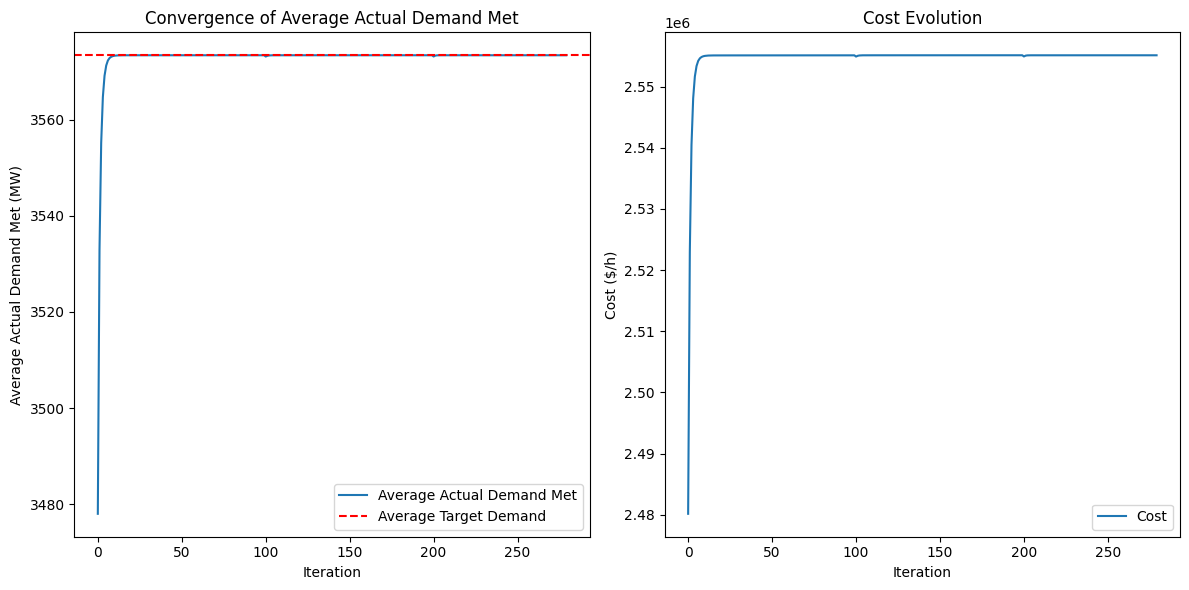

In [23]:

hed = HopfieldEconomicDispatch(data_gen, c0=2000, eta=0.5, iterations=20000)


#initial_state = hed.initialize_state()
solution = hed.solve()

# Note: Printing and analysis of the solution for all timesteps would be extensive. Here's a simplified version:

#print("Generator: Initialization State (MW), Maximum Capacity (MW), Solution Output (MW)")
#for t in range(hed.timesteps):
#    print(f"\nTimestep {t+1}:")
#    for i in range(num_generators):
#        print(f"Generator {i+1}: {initial_state[i + t*num_generators].item():.2f}, {capacities[i].item():.2f}, {solution[i + t*num_generators].item():.2f}")

# Calculate total cost and losses for all timesteps
total_power = solution.sum()
print(f"Total Power Generated: {total_power.item():.2f} MW")
losses = (data_gen.B.repeat(hed.timesteps) * solution**2).sum()
print(f"Transmission Losses: {losses.item():.2f} MW")
actual_demand_met = total_power - losses
print(f"Actual Demand Met: {actual_demand_met.item():.2f} MW")

# Cost calculation across all timesteps
cost = (data_gen.a.repeat(hed.timesteps) + data_gen.b.repeat(hed.timesteps) * solution + data_gen.c.repeat(hed.timesteps) * solution**2).sum()


# Calculate means
mean_actual_demand_met = actual_demand_met.mean().item()
mean_demand = hed.demand.mean().item()

# Print total values and means for power and demand
print(f"\nTotal Power Generated: {total_power.item():.2f} MW")
print(f"Transmission Losses: {losses.item():.2f} MW")
print(f"Actual Demand Met: Mean = {mean_actual_demand_met:.2f} MW, Total = {actual_demand_met.sum().item():.2f} MW (Demand was {data_gen.demand.sum().item():.2f} MW)")
print(f"Demand: Mean = {mean_demand:.2f} MW, Total = {hed.demand.sum().item():.2f} MW")
print(f"Minimized Cost: {cost.item():.2f} $/h")

# Print the entire timeseries
print("\nActual Demand Met Timeseries (MW):")
print(actual_demand_met.tolist())
print("\nDemand Timeseries (MW):")
print(hed.demand.tolist())


#print("Solution (Generator Outputs for All Timesteps):")
#for t in range(hed.timesteps):
#    print(f"\nTimestep {t+1}:")
#    for i in range(hed.n):
#        print(f"  Generator {i+1}: {solution[i + t*hed.n].item():.2f} MW")


# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(hed.actual_demand_met_history)), [np.mean(x) for x in hed.actual_demand_met_history], label='Average Actual Demand Met')
plt.axhline(y=data_gen.demand.mean().item(), color='r', linestyle='--', label='Average Target Demand')
plt.xlabel('Iteration')
plt.ylabel('Average Actual Demand Met (MW)')
plt.title('Convergence of Average Actual Demand Met')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(hed.cost_history)), hed.cost_history, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost ($/h)')
plt.title('Cost Evolution')
plt.legend()

plt.tight_layout()
plt.show()



In [22]:

# Convert history to numpy array for easier manipulation
demand_met_history = np.array(hed.actual_demand_met_history)

# Sample every 50th iteration
step = 1
sampled_demand_met = demand_met_history[::step, :]

# Debug: Print length of history
print(f"Number of iterations in history: {len(demand_met_history)}")

# Debug: Print shape of sampled data
print(f"Shape of sampled data: {sampled_demand_met.shape}")

if sampled_demand_met.size > 0:  # Check if we have any data after sampling
    # Create a grid for the surface plot
    iterations = np.arange(0, len(sampled_demand_met) * step, step)  # Start from 0 with step
    timesteps = np.arange(len(sampled_demand_met[0]))
    X, Y = np.meshgrid(iterations, timesteps)

    # Z will be our demand met values
    Z = sampled_demand_met
    Z = Z.T

    # Create the plotly figure
    fig = go.Figure(data=[go.Surface(z=Z, x=X[0,:], y=Y[:,0])])
    #fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

    # Add the target demand as scatter points above the surface for better visibility
    for i in range(len(demand)):
        fig.add_trace(go.Scatter3d(
            x=iterations,
            y=np.full_like(iterations, i),
            z=demand[i].item() * np.ones_like(iterations),  # Add this line to specify z values
            mode='lines',
            line=dict(color='red', width=4, dash='dash'),
            name=f'Target Demand for Timestep {i}',
            hoverinfo='skip'  # Skip hover info to clean up the plot
        ))

    # Update layout for better visualization
    fig.update_layout(
        title='Evolution of Demand Met Over Iterations and Timesteps (Interactive)',
        scene=dict(
            xaxis_title='Iteration',
            yaxis_title='Timestep',
            xaxis=dict(range=[X.min(), X.max()]),
            yaxis=dict(range=[Y.min(), Y.max()]),
            zaxis=dict(range=[Z.min(), Z.max()], title='Demand Met (MW)'),  # Combine zaxis settings
            aspectratio=dict(x=1, y=1, z=0.7),
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1.25)
            ),
        ),
        autosize=False,
        width=1000,
        height=800,
        margin=dict(l=65, r=50, b=65, t=90)
    )

    # Debug: Print min and max values to check range
    print(f"Min value in Z: {Z.min()}, Max value in Z: {Z.max()}")

    # Display the plot
    fig.show()
else:
    print("No data available after sampling. Check if there are enough iterations or if 'step' is too large.")


Number of iterations in history: 62
Shape of sampled data: (62, 48)
Min value in Z: 1499.7822575587154, Max value in Z: 5000.000127512138


In [30]:
# Convert history to numpy array for easier manipulation
cost_history = np.array(hed.cost_history_per_timestep)

# Sample every 50th iteration (or adjust as needed)
step = 1
sampled_cost = cost_history[::step, :]

# Create a grid for the surface plot
iterations = np.arange(0, len(sampled_cost) * step, step)  # Start from 0 with step
timesteps = np.arange(len(sampled_cost[0]))
X, Y = np.meshgrid(iterations, timesteps)

# Z will be our cost values
Z = sampled_cost
Z = Z.T  # Transpose for Plotly to interpret correctly

# Create the plotly figure
fig = go.Figure(data=[go.Surface(z=Z, x=X[0,:], y=Y[:,0], colorscale='YlOrRd')])

# Add the reference line for cost if needed (optional)
for i in range(len(demand)):  # Assuming demand length corresponds to timesteps
    fig.add_trace(go.Scatter3d(
        x=iterations,
        y=np.full_like(iterations, i),
        z=np.full_like(iterations, np.mean(cost_history[:, i])),  # Average cost over iterations for each timestep
        mode='lines',
        line=dict(color='blue', width=2, dash='dash'),
        name=f'Average Cost for Timestep {i}',
        hoverinfo='skip'
    ))

# Update layout for better visualization
fig.update_layout(
    title='Evolution of Cost Over Iterations and Timesteps (Interactive)',
    scene=dict(
        xaxis_title='Iteration',
        yaxis_title='Timestep',
        zaxis_title='Cost ($/h)',
        aspectratio=dict(x=1, y=1, z=0.7),
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)
        ),
    ),
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Display the plot
fig.show()

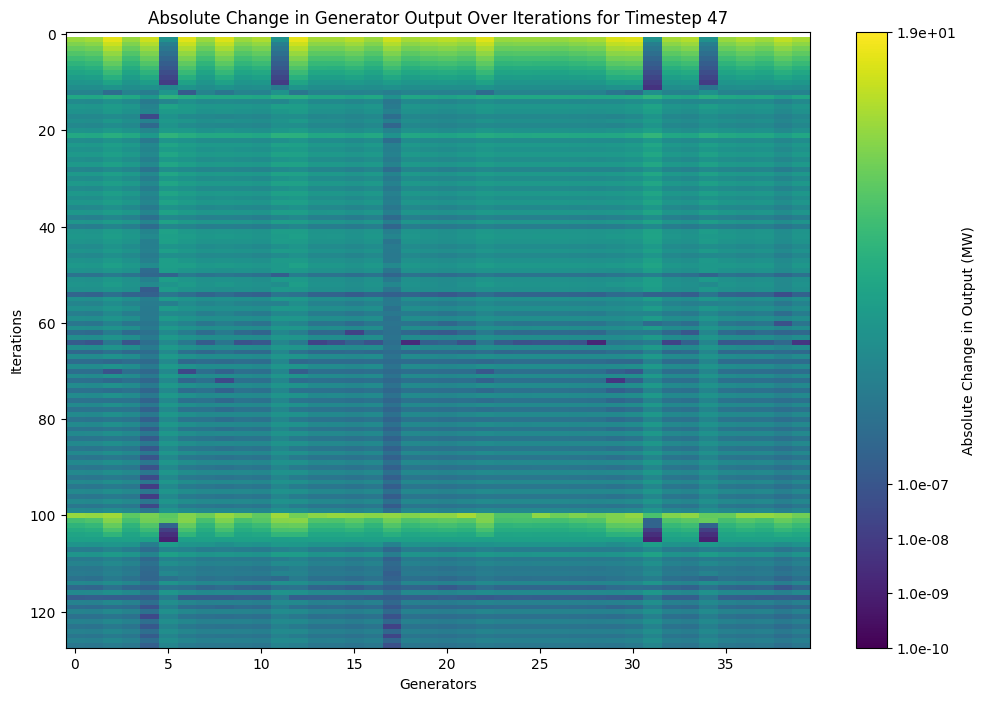

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors

# Assuming `hed.generator_outputs_history` contains outputs for all iterations
generator_outputs = np.array(hed.generator_outputs_history)
generator_outputs = generator_outputs.reshape(-1, hed.timesteps, hed.n)  # (iterations, timesteps, generators)

# Calculate absolute difference from last iteration
abs_diff = np.zeros_like(generator_outputs)
for i in range(1, generator_outputs.shape[0]):  # Start from the second iteration
    abs_diff[i] = np.abs(generator_outputs[i] - generator_outputs[i-1])

# Handle the first iteration where there's no previous state
abs_diff[0] = np.zeros_like(generator_outputs[0])  # Set to 0 since there's no change from "previous" state

# Transpose to get shape (timesteps, iterations, generators) for the animation
abs_diff = abs_diff.transpose(1, 0, 2)

# Create figure and axis for animation
fig, ax = plt.subplots(figsize=(12, 8))

# Use a logarithmic scale for better visibility of low values
vmax = abs_diff.max()
vmin = abs_diff.min()
if vmin == 0:
    vmin = 1e-10  # To avoid log(0)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Initialize an empty plot
im = ax.imshow(abs_diff[0, :, :], aspect='auto', cmap='viridis', norm=norm)

# Set labels and title
ax.set_xlabel('Generators')
ax.set_ylabel('Iterations')
ax.set_title('Absolute Change in Generator Output Over Iterations for Timestep 0')

# Adjust colorbar for log scale
cbar = plt.colorbar(im, ax=ax, label='Absolute Change in Output (MW)')
cbar.set_ticks([vmin, vmin * 10, vmin * 100, vmin * 1000, vmax])
cbar.set_ticklabels([f'{vmin:.1e}', f'{vmin*10:.1e}', f'{vmin*100:.1e}', f'{vmin*1000:.1e}', f'{vmax:.1e}'])

# Animation update function
def update(frame):
    # Frame here refers to the timestep
    im.set_array(abs_diff[frame, :, :])
    ax.set_title(f'Absolute Change in Generator Output Over Iterations for Timestep {frame}')
    return [im]

# Create animation
anim = animation.FuncAnimation(fig, update, frames=hed.timesteps, interval=500, blit=True)

# To display the animation in a Jupyter notebook or save it
from IPython.display import HTML
HTML(anim.to_jshtml())
# Or to save as a .gif or .mp4
# anim.save('generator_output_absolute_change_log_animation.gif', writer='pillow')

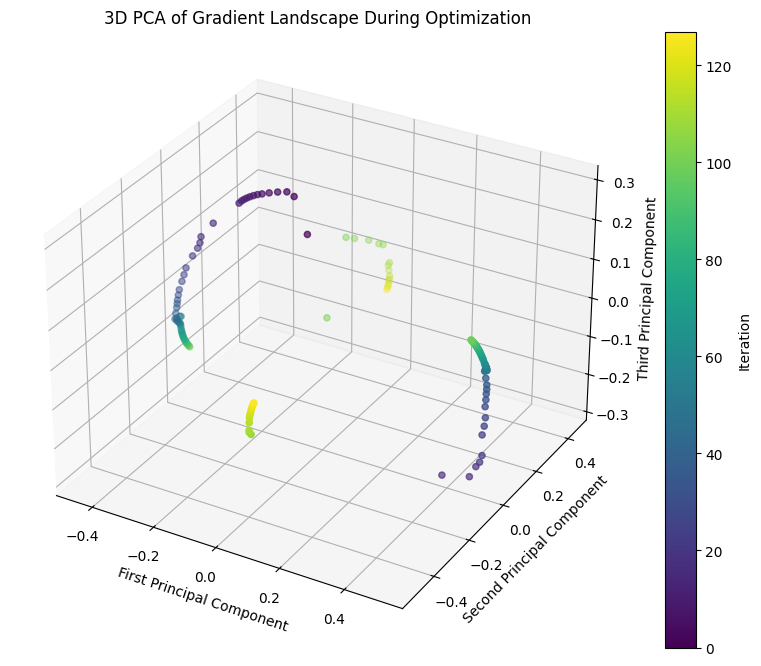

Explained variance ratio: [0.70488653 0.19729586 0.07085677]


In [32]:
# Convert gradient history to numpy array for PCA
gradients_array = np.array(hed.gradient_history)

# Apply PCA to get 3 components
pca = PCA(n_components=3)  # Now we want 3 components
X_pca = pca.fit_transform(gradients_array)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D where each point represents an iteration
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=range(len(X_pca)), cmap='viridis')

# Labels and title
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
plt.title('3D PCA of Gradient Landscape During Optimization')

# Add a color bar to show iteration progression
cbar = plt.colorbar(scatter, ax=ax, label='Iteration')

# Show the plot
plt.show()

# Print explained variance ratio to understand how much information is retained
print("Explained variance ratio:", pca.explained_variance_ratio_)

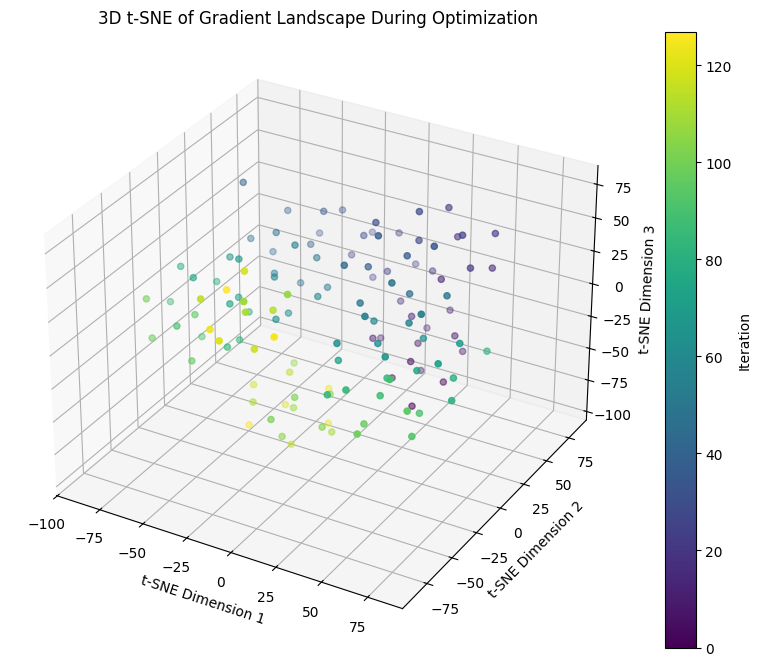

In [34]:
# Convert gradient history to numpy array for t-SNE
gradients_array = np.array(hed.gradient_history)

# Apply t-SNE to get 3 components
tsne = TSNE(n_components=3, random_state=42)  # Random state for reproducibility
X_tsne = tsne.fit_transform(gradients_array)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D where each point represents an iteration
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=range(len(X_tsne)), cmap='viridis')

# Labels and title
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.title('3D t-SNE of Gradient Landscape During Optimization')

# Add a color bar to show iteration progression
cbar = plt.colorbar(scatter, ax=ax, label='Iteration')

# Show the plot
plt.show()